In [1]:
import numpy as np
import random
import math
from types import SimpleNamespace
import numpy as np
import scipy as sp
from scipy import linalg
from scipy import optimize
from scipy import interpolate
import sympy as sm

%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

# Import additional libraries: 


ModuleNotFoundError: No module named 'numpy'

# Consumption saving with borrowing

In [2]:
# Parameters
rho = 3
kappa = 0.5
nu = 0.1
r = 0.04
beta = 0.95
Delta = 0.5
# Add income prb parameters
type1=dict()

type1['plow'] =0.9
type1['phigh']=0.1

type2=dict()
type2['plow']=0.1
type2['phigh']=0.9

**Question 1** Solve the model for each type of household. Plot the value functions $v_1(m_1)$ and $v_2(m_2)$ in one graph for each household type. Comment on the differences.

**Question 2** From the model solution, obtain the optimal consumption functions $c_1^*(m_1)$ and $c_2^*(m_2)$. Plot these in one graph for each type of household. Comment on the observed differences between household types. 

In [3]:
def utility(c,rho):
    return c**(1-rho)/(1-rho)

def bequest(m,c,nu,kappa,rho):
    return nu*(m-c+kappa)**(1-rho)/(1-rho)

# Define the value function in period 2
def v2(c2,m2,rho,nu,kappa):
    return utility(c2,rho) + bequest(m2,c2,nu,kappa,rho)

Define the v1(m) function here. Since we have two different types of households, 

In [19]:
#Define value function in period 
def v1(c1,m1,rho,beta,r,Delta,v2_interp,plow,phigh):
    
    # a. v2 value, if low income
    m2_low = (1+r)*(m1-c1) + 1-Delta
    v2_low = v2_interp([m2_low])[0]
    
    # b. v2 value, if high income
    m2_high = (1+r)*(m1-c1) + 1+Delta
    v2_high = v2_interp([m2_high])[0]
    
    # c. expected v2 value
    v2 = plow*v2_low + phigh*v2_high
    
    # d. total value
    return utility(c1,rho) + beta*v2

In [20]:
# Construct interpolor 
v2_interp = interpolate.RegularGridInterpolator([m2_vec], v2_vec,
                                                bounds_error=False,fill_value=None)

In [25]:
def solve_period_2(rho,nu,kappa,Delta):

    # a. grids
    m2_vec = np.linspace(1e-8,5,500)
    v2_vec = np.empty(500)
    c2_vec = np.empty(500)

    # b. solve for each m2 in grid
    for i,m2 in enumerate(m2_vec):

        # i. objective
        obj = lambda x: -v2(x[0],m2,rho,nu,kappa)

        # ii. initial value (consume half)
        x0 = m2/2

        # iii. optimizer
        result = optimize.minimize(obj,[x0],method='L-BFGS-B',bounds=((1e-8,m2),))

        # iv. save
        v2_vec[i] = -result.fun
        c2_vec[i] = result.x
        
    return m2_vec,v2_vec,c2_vec



/Users/weichuhao/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:579: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx


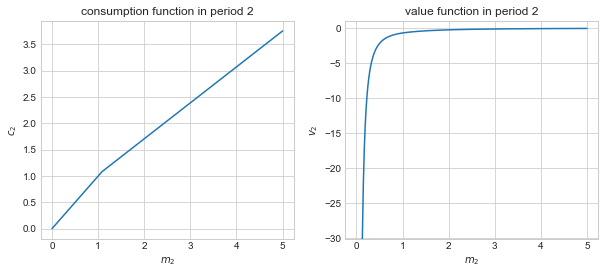

In [27]:
# solve the period 2 
m2_vec,v2_vec,c2_vec = solve_period_2(rho,nu,kappa,Delta)

# illustration
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(1,2,1)
ax.plot(m2_vec,c2_vec)
ax.set_xlabel('$m_2$')
ax.set_ylabel('$c_2$')
ax.set_title('consumption function in period 2')

ax = fig.add_subplot(1,2,2)
ax.plot(m2_vec,v2_vec)
ax.set_xlabel('$m_2$')
ax.set_ylabel('$v_2$')
ax.set_title('value function in period 2')
ax.set_ylim([-30,1]);

### Comments : 
Since in the period2, delta, plow and phigh are exogeneous variables, the consumption function and value are indifferent for the two household types.

### Solve the first period

The main extension here in this problem is that households can borrow in period 1. Therefore, the bound of the c1 is not m1, but equals to (1-delta)/(1+r) + m1 

In [22]:
def solve_period_1(rho,beta,r,Delta,v2_interp,plow,phigh):

    # a. grids
    m1_vec = np.linspace(1e-8,4,100)
    v1_vec = np.empty(100)
    c1_vec = np.empty(100)
    
    # b. solve for each m1 in grid
    for i,m1 in enumerate(m1_vec):
        
        # i. objective
        obj = lambda x: -v1(x[0],m1,rho,beta,r,Delta,v2_interp,plow,phigh)
        
        # ii. initial guess (consume half)
        x0 = m1/2
        
        # iii. optimize
        result = optimize.minimize(obj,[x0],method='L-BFGS-B',bounds=((1e-12,(1-delta)/(1+r)+m1),))
        
        # iv. save
        v1_vec[i] = -result.fun
        c1_vec[i] = result.x[0]
     
    return m1_vec,v1_vec,c1_vec


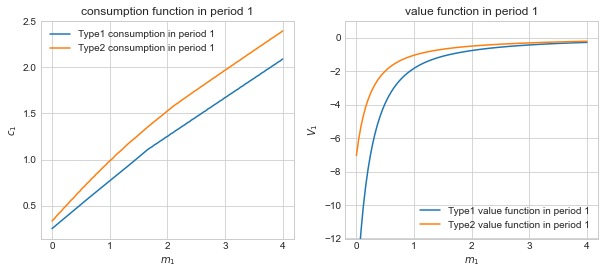

In [24]:
# solve function for two different types of households
delta=0.25
m1_vec_type1,v1_vec_type1,c1_vec_type1 = solve_period_1(rho,beta,r,Delta,v2_interp,type1['plow'],type1['phigh'])
m1_vec_type2,v1_vec_type2,c1_vec_type2 = solve_period_1(rho,beta,r,Delta,v2_interp,type2['plow'],type2['phigh'])

# illustrate
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(1,2,1)
ax.plot(m1_vec_type1,c1_vec_type1,label='Type1 consumption in period 1')
ax.plot(m1_vec_type2,c1_vec_type2,label='Type2 consumption in period 1')
ax.set_xlabel('$m_1$')
ax.set_ylabel('$c_1$')
ax.set_title('consumption function in period 1')
ax.legend()

ax = fig.add_subplot(1,2,2)
ax.plot(m1_vec_type1,v1_vec_type1,label='Type1 value function in period 1')
ax.plot(m1_vec_type2,v1_vec_type2,label='Type2 value function in period 1')
ax.set_xlabel('$m_1$')
ax.set_ylabel('$V_1$')
ax.set_title('value function in period 1')
ax.legend()
ax.set_ylim([-12,1]);

### Comments: 
In period 1 , the value function is the value of the whole life since we considered the expection value in period 2. In the consumption function, type2 households prefer to consume more than type1 households. The gaps increase at first and become constant after some moments. Intuitively, this outcome are reasonable because type 2 households can get more income in period 2, so they can consume more. When the m1 get larger and larger , the influence of y2 decreases because the fraction of y2 get smaller. This has been proved in the value function, the value of type2 are larger that type1 at first but get closer and closer as the m1 increase.



In [31]:
def solve(rho,beta,r,Delta,nu,kappa,plow,phigh):
    
    # a. solve period 2
    m2_vec,v2_vec,c2_vec = solve_period_2(rho,nu,kappa,Delta)
    
    # b. construct interpolator
    v2_interp = interpolate.RegularGridInterpolator([m2_vec], v2_vec,
        bounds_error=False,fill_value=None)
    
    # b. solve period 1
    m1_vec,v1_vec,c1_vec = solve_period_1(rho,beta,r,Delta,v2_interp,plow,phigh)
    
    return m1_vec,c1_vec,m2_vec,c2_vec

**Plot consumption function for various level of income risk**, i.e varios $\Delta$

/Users/weichuhao/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:579: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
/Users/weichuhao/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:579: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
/Users/weichuhao/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:579: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
/Users/weichuhao/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:579: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
/Users/weichuhao/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:579: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
/Users/weichuhao/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:579: RuntimeWarning: invalid value

(0.0, 1.5)

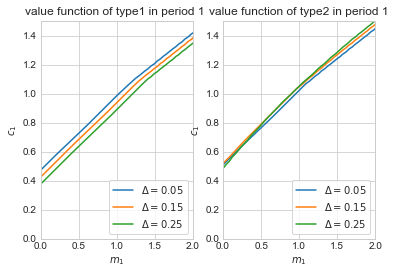

In [33]:
fig = plt.figure()
ax = fig.add_subplot(1,2,1)

for Delta in [0.05,0.15,0.25]:
    m1_vec,c1_vec,m2_vec,c2_vec = solve(rho,beta,r,Delta,nu,kappa,type1['plow'],type1['phigh'])
    ax.plot(m1_vec,c1_vec,label=f'$\Delta = {Delta}$')

ax.legend(loc='lower right',facecolor='white',frameon=True)
ax.set_xlabel('$m_1$')
ax.set_ylabel('$c_1$')
ax.set_title('value function of type1 in period 1 ')
ax.set_xlim([0,2])
ax.set_ylim([0,1.5])

ax = fig.add_subplot(1,2,2)

for Delta in [0.05,0.15,0.25]:
    m1_vec,c1_vec,m2_vec,c2_vec = solve(rho,beta,r,Delta,nu,kappa,type2['plow'],type2['phigh'])
    ax.plot(m1_vec,c1_vec,label=f'$\Delta = {Delta}$')

ax.legend(loc='lower right',facecolor='white',frameon=True)
ax.set_xlabel('$m_1$')
ax.set_ylabel('$c_1$')
ax.set_title('value function of type2 in period 1')
ax.set_xlim([0,2])
ax.set_ylim([0,1.5])

**Question 3** Simulate `simN` households of each type based on the distribution of $m_1$ below. You can use the same distribution for both household types. What is the fraction of households who *borrow* in period 1, $c_1 > m_1$, in each group?

In [34]:
np.random.seed(2021)
simN = 1000
# No one gets negative m in first period
sim_m1 = np.fmax(np.random.normal(1, 1, size = simN), 0) 

In [38]:
# Consturct the interploators
Delta = 0.25
m1_vec_type1,c1_vec_type1,m2_vec_type1,c2_vec_type1 = solve(rho,beta,r,Delta,nu,kappa,type1['plow'],type1['phigh'])

m1_vec_type2,c1_vec_type2,m2_vec_type2,c2_vec_type2 = solve(rho,beta,r,Delta,nu,kappa,type2['plow'],type2['phigh'])

c1_interp_type1 = interpolate.RegularGridInterpolator([m1_vec_type1], c1_vec_type1,
                                                bounds_error=False,fill_value=None)

c1_interp_type2 = interpolate.RegularGridInterpolator([m1_vec_type2], c1_vec_type2,
                                                bounds_error=False,fill_value=None)


c2_interp_type1 = interpolate.RegularGridInterpolator([m2_vec_type1], c2_vec_type1,
                                                bounds_error=False,fill_value=None)

c2_interp_type2 = interpolate.RegularGridInterpolator([m2_vec_type2], c2_vec_type2,
                                                bounds_error=False,fill_value=None)

/Users/weichuhao/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:579: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx


In [40]:
# b. period 1
sim_c1_type1 = c1_interp_type1(sim_m1)
sim_a1_type1 = sim_m1-sim_c1_type1

sim_c1_type2 = c1_interp_type2(sim_m1)
sim_a1_type2 = sim_m1-sim_c1_type2

# c. transition to period 2 with random draw
sim_m2_type1 = (1+r)*sim_a1_type1+np.random.choice([0.5,1.5],p=[0.5,0.5])
sim_m2_type2 = (1+r)*sim_a1_type2+np.random.choice([0.5,1.5],p=[0.5,0.5])
# d. period 2
sim_c2_type1 = c2_interp(sim_m2_type1)
sim_c2_type2 = c2_interp(sim_m2_type2)

Text(0.5, 1.0, 'consumption for type 2')

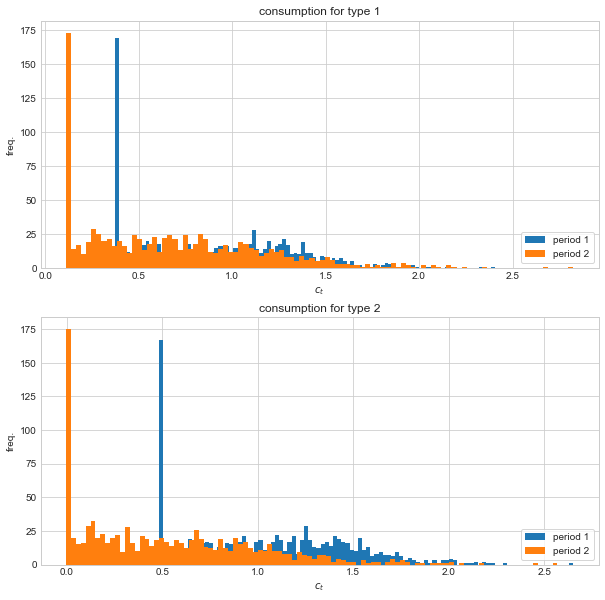

In [46]:
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(2,1,1)

ax.hist(sim_c1_type1,bins=100,label='period 1')
ax.hist(sim_m2_type1,bins=100,label='period 2')

ax.legend(loc='lower right',facecolor='white',frameon=True)
ax.set_xlabel('$c_t$')
ax.set_ylabel('freq.')
ax.set_title('consumption for type 1')

ax = fig.add_subplot(2,1,2)

ax.hist(sim_c1_type2,bins=100,label='period 1')
ax.hist(sim_m2_type2,bins=100,label='period 2')

ax.legend(loc='lower right',facecolor='white',frameon=True)
ax.set_xlabel('$c_t$')
ax.set_ylabel('freq.')
ax.set_title('consumption for type 2')

In [47]:
# fraction of households in type 1who borrow in period 1
sum(sim_c1_type1>sim_m1)/len(sim_c1_type1)

0.424

In [48]:
# fraction of households in type 1who borrow in period 1
sum(sim_c1_type2>sim_m1)/len(sim_c1_type2)

0.533

### Therefore, the fraction of people who borrow in period 1 is larger in type2 than type2